In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs # Cartopy map projections
import cartopy.feature as cfeature
import xarray as xr

# EXAMPLE 1:  Working with complex date, time information
 - plate motion measured by GPS instruments from 1995/1997 until 2025 in:
   - Reykjavik (North American plate): http://geodesy.unr.edu/NGLStationPages/stations/REYK.sta 
   - Hofn (Eurasian plate): http://geodesy.unr.edu/NGLStationPages/stations/HOFN.sta 

In [14]:
filename1= 'REYK_all.txt'
reyk = pd.read_csv(filename1,sep=r'\s+')

filename2 = 'HOFN_all.txt'
hofn = pd.read_csv(filename2,sep=r'\s+')
print(hofn.head())

   site  YYMMMDD  yyyy.yyyy  __MJD  week  d  reflon  _e0(m)  __east(m)  \
0  HOFN  97JUN29  1997.4921  50628   912  0   -15.2     100   0.684539   
1  HOFN  97JUN30  1997.4949  50629   912  1   -15.2     100   0.683427   
2  HOFN  97JUL01  1997.4976  50630   912  2   -15.2     100   0.683983   
3  HOFN  97JUL02  1997.5003  50631   912  3   -15.2     100   0.682999   
4  HOFN  97JUL03  1997.5031  50632   912  4   -15.2     100   0.683407   

   ____n0(m)  ...  _ant(m)  sig_e(m)  sig_n(m)  sig_u(m)  __corr_en  \
0    7129651  ...    0.055  0.000898  0.001324  0.004191  -0.082970   
1    7129651  ...    0.055  0.000794  0.001174  0.003689  -0.034179   
2    7129651  ...    0.055  0.000825  0.001154  0.003953  -0.028427   
3    7129651  ...    0.055  0.000863  0.001333  0.003986  -0.084764   
4    7129651  ...    0.055  0.000780  0.001143  0.003612  -0.051914   

   __corr_eu  __corr_nu  _latitude(deg)  _longitude(deg)  __height(m)  
0   0.078434   0.015954       64.267291       -15.197922

##### Let's deal with date-time data...it's messy
  - we used the '_MJD' column - this is time in 'Modified Julian time.'  We can look that up and see that we'll have to add a certain # to modified Julian time to get into traditional Julian time.  We'll also have to specify unit as day ('D'), and origin of the time as 'julian'
  - source:  https://core2.gsfc.nasa.gov/time/

In [15]:
# (i)
hofn['times'] = pd.to_datetime(hofn['__MJD']+2400000.5,unit='D',origin='julian')
reyk['times'] = pd.to_datetime(reyk['__MJD']+2400000.5,unit='D',origin='julian')

print(reyk['times'])

print(reyk.columns)

0       1995-12-31
1       1996-01-01
2       1996-01-02
3       1996-01-03
4       1996-01-04
           ...    
10382   2025-10-06
10383   2025-10-07
10384   2025-10-08
10385   2025-10-09
10386   2025-10-10
Name: times, Length: 10387, dtype: datetime64[ns]
Index(['site', 'YYMMMDD', 'yyyy.yyyy', '__MJD', 'week', 'd', 'reflon',
       '_e0(m)', '__east(m)', '____n0(m)', '_north(m)', 'u0(m)', '____up(m)',
       '_ant(m)', 'sig_e(m)', 'sig_n(m)', 'sig_u(m)', '__corr_en', '__corr_eu',
       '__corr_nu', '_latitude(deg)', '_longitude(deg)', '__height(m)',
       'times'],
      dtype='object')


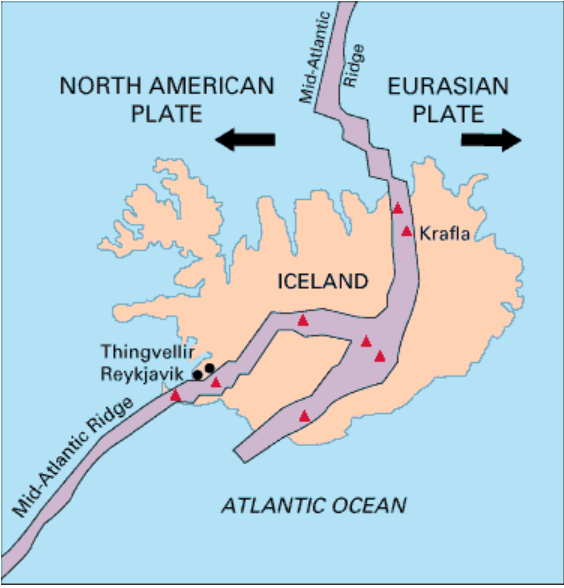

# EXAMPLE 2:  More uses of argmax - monthly mean surface air temperature data (from Week 9 lessons)

## Science Q: Which locations see the highest monthly mean surface air temperatures?

In [16]:
da = xr.open_dataarray('air.mon.mean.nc',decode_times=True)
print(da)

<xarray.DataArray 'air' (time: 873, lat: 73, lon: 144)> Size: 37MB
[9176976 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2020-09-01
Attributes:
    long_name:     Monthly Mean Air Temperature at sigma level 0.995
    valid_range:   [-2000.  2000.]
    units:         degC
    precision:     1
    var_desc:      Air Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Obs
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [-73.78001  42.14595]


In [17]:
max_loc = da.argmax(dim=['lat','lon']) #  We want, for each time (which is monthly average, so for each month), the location with the warmest temperature
max_temp = da.max(dim=['lat','lon'])

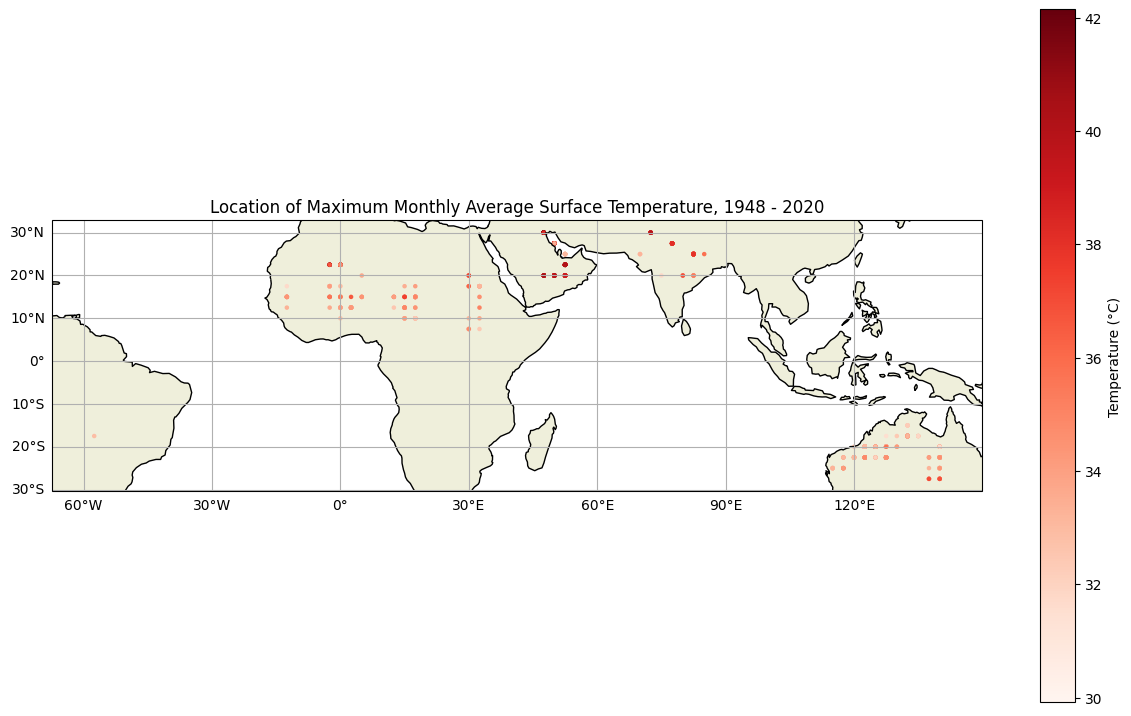

In [18]:
cmap = plt.colormaps['Reds']

lat_min = da['lat'].isel(lat=max_loc['lat']) 
lon_min = da['lon'].isel(lon=max_loc['lon'])

# Plotting time! Mwahaha!

fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(15,15))
cs = ax.scatter(lon_min,lat_min,c=max_temp,cmap=cmap,s=5,transform=ccrs.PlateCarree()) # c is the option that sets the color, and we can set it to an array

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

cb = plt.colorbar(cs, shrink=0.6, ax=ax)
cb.set_label('Temperature (°C)')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.set_title('Location of Maximum Monthly Average Surface Temperature, ' + str(np.array(da.time.min().dt.year)) + ' - '+ str(np.array(da.time.max().dt.year)))

plt.show()

In [19]:
# Q: Why are the warmest temperatures not directly on or near the equator?
# A: Closer to the equator, we have lots of clouds, storms, low pressure. ~30 deg N, S, region of high pressure as descending branch of Hadley cell.  
# This results in more arid (drier) regions.  In drier regions, more radiation goes into warming the air vs. evaporative processes.

# Q: How could we better express on the above plot how many times a given location is the location of the max average monthly temperature for a given month?
# Marker size scaled by number of times location was maximum location.  Then have to decide if still want to color marker, by most recent max temperature value?

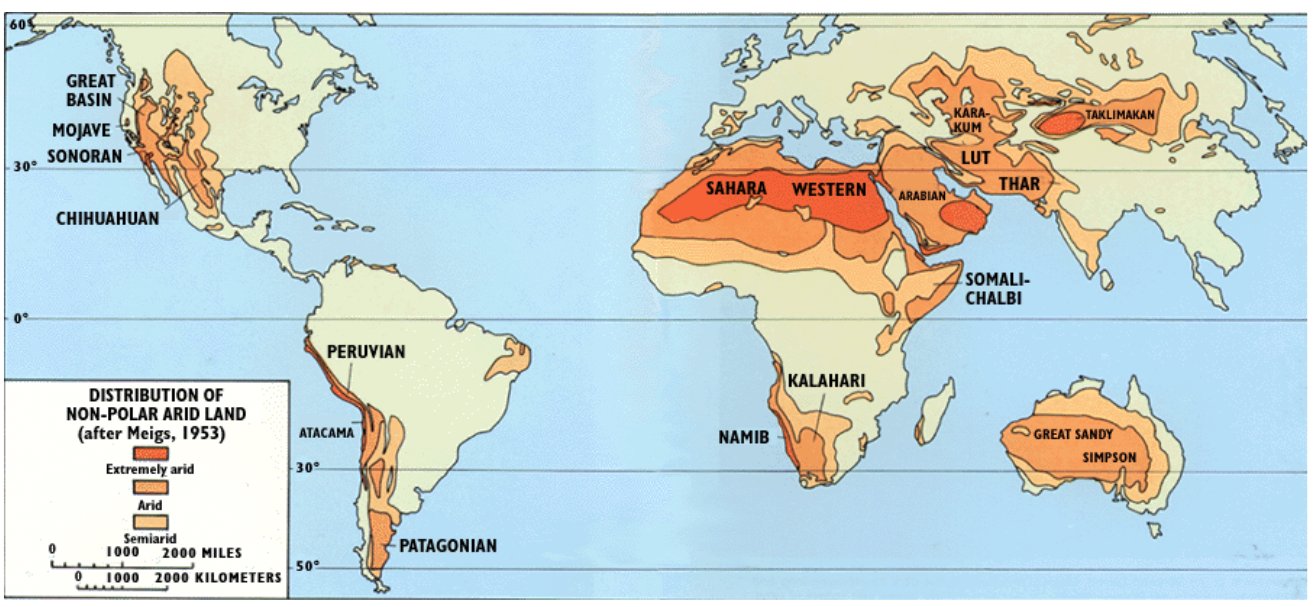

In [20]:
# There are lots of dots being plotted on top of each other.  What could we do to better visualize this data?




# EXAMPLE 3:  More uses of grouping by temperature - Week 10 In-Mod Exercises Radiation Data

## Science Q: Can we see diurnal cycle in temperatures?

In [21]:
# Need to skip the first two rows
rad = pd.read_csv('889299_40.13_-88.26_2019.csv',skiprows=2)

# My, isn't this nice and straightforward!  "Clean" date-time columns like this ftw!
rad['time']=pd.to_datetime(rad[['Year','Month','Day','Hour','Minute']])

Text(0.5, 1.0, 'Mean Temperature, Each Hour of Day')

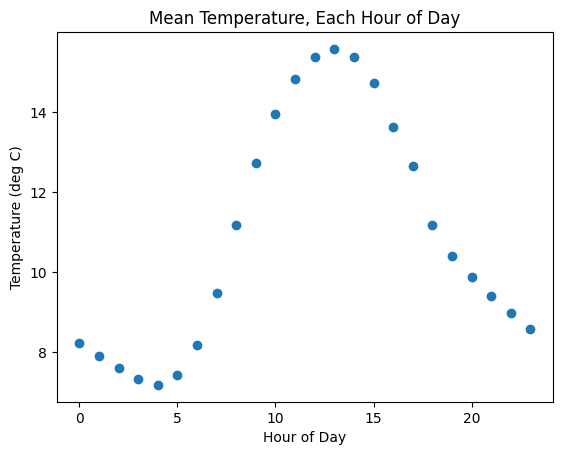

In [22]:
# let's work with hour of day!
hours = rad['time'].dt.hour
hourly_averages = rad['Temperature'].groupby(hours).mean()

fig, ax = plt.subplots()
ax.scatter(hourly_averages.index,hourly_averages)
ax.set_ylabel('Temperature (deg C)')
ax.set_xlabel('Hour of Day')
ax.set_title('Mean Temperature, Each Hour of Day')

In [23]:
# Yay, diurnal cycle!  Maximum temperature each day in afternoon - makes sense!